# STARLINK Orbit Altitude History

### Robert Cameron, May 2020

In [1]:
from astropy.table import Table, Column
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt
import re
%matplotlib inline

/Users/rac/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# TLE Line 1
# Column  Description
# ======  ===========
# 01      Line Number of Element Data = 1
# 03-07   Satellite Number (FGST = 33053)
# 08      Classification (U = Unclassified)
# 10-11   International Designator (Last two digits of launch year) (FGST = 08)
# 12-14   International Designator (Launch number of the year) (FGST = 029)
# 15-17   International Designator (Piece of the launch) (FGST = "A  ")
# 19-20   Epoch Year (Last two digits of year)
# 21-32   Epoch (Day of the year and fractional portion of the day) (123.56789012)
# 34-43   First Time Derivative of the Mean Motion ( .67890123 =  .00000NNN)
# 45-52   Second Time Derivative of Mean Motion (decimal point assumed) ( 67890-2 =  00000-0)
# 54-61   BSTAR drag term (decimal point assumed) ( 5678901 =  NNNNN-N)
# 63      Ephemeris type (generally = 0)
# 65-68   Element number ( NNN)
# 69      Checksum (Modulo 10) (Letters, blanks, periods, plus signs = 0; minus signs = 1)

# TLE Line 2
# Column  Description
# ======  ===========
# 01      Line Number of Element Data = 2
# 03-07   Satellite Number (FGST = 33053)
# 09-16   Inclination [Degrees] (FGST = 25.58NN degrees)
# 18-25   Right Ascension of the Ascending Node [Degrees] (890.2345 = NNN.NNNN)
# 27-33   Eccentricity (decimal point assumed) (7890123, FGST = 001NNNN)
# 35-42   Argument of Perigee [Degrees] (567.9012 = NNN.NNNN)
# 44-51   Mean Anomaly [Degrees] (456.8901 = NNN.NNNN)
# 53-63   Mean Motion [Revs per day] (34.67890123, FGST = 15.NNNNnnnn)
# 64-68   Revolution number at epoch [Revs] (45678 = NNNNN)
# 69      Checksum (Modulo 10)

r1 = '^1(.{17})(\d{2})(.{12}) (.{13}) (\d{5})-(\d{1})  (\d{5})[-+](\d{1}) (\d{1}) (.{4})(\d{1})'
r1 = '^1(.{17})(\d{2})(.{12}) (.{9})'
r2 = '^2(.{7})(.{8}) (.{8}) (.{7}) (.{8}) (.{8}) (.{11})(.{5})(\d{1})'
p1 = re.compile(r1)
p2 = re.compile(r2)

In [3]:
outfmt1 = "{0:10.5f} {1:5d} {2:9.6f} {3:8.2e} {4:8.3f} {5:8.3f} {6:7.3f} "
outfmt1 = "{0:10.5f} {1:5d} {2:9.6f} {3:s} {4:8.3f} {5:8.3f} {6:7.3f} "
outfmt2 = "{0:7.4f} {1:9.4e} {2:8.4f} {3:8.4f} {4:8.4f} {5:8.5f} {6:6.3f}\n"

R_earth = 6378
pi = 3.14159265359
GM = 398600.44  # km^3 s^-2 (Wertz 1978)

def TLE2df(tlefile,SatID,LaunchID,fout):

    fy = []
    orbit = []
    MM = []
    MMdot = []
    PerS = []
    smaj = []
    alt = []
    inc = []
    ecc = []
    RAAN = []
    MeanAnom = []
    ArgPer = []
    prec = []
    PrecP = []

# read regular ASCII tabular file of Fermi 2-line TLE records

    one = ""
    two = ""
    need = 1
    prev = {}
    row = 0
    badrows = 0
    rows1 = 0
    rows2 = 0
    rows12 = 0

    with open(tlefile,'r') as ft:
        for line in ft:
            line = line.rstrip()
            if SatID not in line:
                badrows += 1
                continue
            if "1 "+SatID+"U "+LaunchID in line:
                need = 2
                one = line
                rows1 += 1
            if "2 "+SatID in line:
                need = 1
                two = line
                rows2 += 1
            if (one and two):
                rows12 += 1
                if one not in prev:
                    m1 = p1.match(one)
                    year = int(m1.group(2))
                    doy = float(m1.group(3))
                    MMdot.append(m1.group(4))
                    ylen = (365, 366)[bool(year % 4)]
                    fy.append(round(year + 2000 + doy/ylen,6))
                    m2 = p2.match(two)
                    
                    inc.append(float(m2.group(2)))
                    RAAN.append(float(m2.group(3)))
                    ecc.append(float(m2.group(4))/1.0e7)
                    ArgPer.append(float(m2.group(5)))
                    MeanAnom.append(float(m2.group(6)))
                    MM.append(float(m2.group(7)))
                    orbit.append(int(m2.group(8)))
                    
#                    inc.append(float(m2.group(1)))
#                    RAAN.append(float(m2.group(2)))
#                    ecc.append(float(m2.group(3))/1.0e7)
#                    ArgPer.append(float(m2.group(4)))
#                    MeanAnom.append(float(m2.group(5)))
#                    MM.append(float(m2.group(6)))
#                    orbit.append(int(m2.group(7)))
                    
                    PerS.append(86400.0/float(MM[-1]))
                    semimajor = (GM*(PerS[-1]/2/pi)**2.0)**0.333333333333   # km
                    smaj.append(round(semimajor,4))
                    alt.append(smaj[-1] - R_earth)    # km
                    ecc_term = (1.0-ecc[-1]**2.0)**2.0
                    inc_term = -2.06474e14 * np.cos(inc[-1]*pi/180)
                    prec_rate = inc_term /(ecc_term * (semimajor**3.5))  # deg/day
                    prec.append(round(prec_rate,5))
                    PrecP.append(round(abs(360/prec_rate),3))     # days
                    outlist1 = (fy[-1],orbit[-1],MM[-1],MMdot[-1],PerS[-1],smaj[-1],alt[-1])
                    outlist2 = (inc[-1],ecc[-1],RAAN[-1],MeanAnom[-1],ArgPer[-1],prec[-1],PrecP[-1])
                    outstr1 = outfmt1.format(*outlist1)
                    outstr2 = outfmt2.format(*outlist2)
                    fout.write(outstr1+outstr2)
                    row += 1
                prev[one] = 1
                one = ""
                two = ""
            
    ft.close()
    print (row,"unique TLEs read from TLE history file:",badrows, rows1, rows2, rows12)
    ltup = list(zip(fy,orbit,MM,MMdot,PerS,smaj,alt,inc,ecc,RAAN,MeanAnom,ArgPer,prec,PrecP))       
# Convert lists of tuples into output pandas Dataframe. 
    dfcols=['fy','orbit','MM','MMdot','PerS','smaj','alt','inc','ecc','RAAN','MeanAnom','ArgPer','prec','PrecP']
    DFout = pd.DataFrame(ltup,columns=dfcols)  
    return(DFout)

In [4]:
# read in Fermi TLE data into Dataframe and send to output file

SatID = "33053"
LaunchID = "08029A"

path = "/Users/rac/Documents/GLAST/"
# input file = history listing of TLE orbit parameter records for Fermi
tlefile = path+"FGST-TLE.txt"

path2 = "/Users/rac/Documents/GLAST/ISOC/LATmetrics/Hubble-STARLINK-TLE/FGST-TLE2/"
tlefile = path2+"FGST.tle.txt"

# read TLE file of Fermi orbit history
outfile = path+"ISOC/LATmetrics/orbit/Fermi-TLE-orbit-history2.txt"
h1="Year      Orbit MeanMot(o/d) MMdot Period(s) SemiMajor(km) Alt  "
h2="Inclin   Eccen     RAAN   MeanAnom ArgPer PrecRate PrecPer(d)\n"
h = h1 + h2   # 14 variables per line
ffout = open(outfile, 'w')
ffout.write(h)
fdf = TLE2df(tlefile,SatID,LaunchID,ffout)
ffout.close()

fdf

5607 unique TLEs read from TLE history file: 0 5613 5613 5613


,fy,orbit,MM,MMdot,PerS,smaj,alt,inc,ecc,RAAN,MeanAnom,ArgPer,prec,PrecP
0,2008.448729,2,15.048424,.0000027,5741.465096,6930.1265,552.1265,25.5874,0.001382,324.0757,147.6708,212.3774,-6.72117,53.562
1,2008.448910,3,15.048448,.0000027,5741.455917,6930.1192,552.1192,25.5880,0.001384,323.6291,146.7275,213.2401,-6.72116,53.562
2,2008.448970,3,15.048442,.0000027,5741.458065,6930.1209,552.1209,25.5885,0.001393,323.4829,264.4587,213.3784,-6.72112,53.562
3,2008.451454,17,15.048499,+.0000027,5741.436245,6930.1033,552.1033,25.5869,0.001396,317.3720,136.0938,223.8528,-6.72127,53.561
4,2008.452180,21,15.048498,.0000027,5741.436703,6930.1037,552.1037,25.5865,0.001394,315.5844,133.0560,226.8805,-6.72129,53.561
5,2008.454179,32,15.048503,+.0000027,5741.434929,6930.1023,552.1023,25.5860,0.001386,310.6688,124.4932,235.4327,-6.72133,53.561
6,2008.455996,42,15.048503,.0000027,5741.434742,6930.1021,552.1021,25.5861,0.001387,306.2008,116.8529,243.0593,-6.72132,53.561
7,2008.456722,46,15.048504,+.0000027,5741.434387,6930.1018,552.1018,25.5856,0.001387,304.4133,113.7302,246.1791,-6.72135,53.561
8,2008.459447,61,15.048505,.0000027,5741.434181,6930.1017,552.1017,25.5854,0.001387,297.7110,102.3016,257.5968,-6.72136,53.561
9,2008.462173,76,15.048505,+.0000027,5741.433986,6930.1015,552.1015,25.5851,0.001387,291.0086,90.8933,269.0017,-6.72138,53.560


In [5]:
# read in STARLINK TLE data into Dataframe and send to output file

path = "/Users/rac/Documents/GLAST/ISOC/LATmetrics/Hubble-STARLINK-TLE/"
tlefile = path + "STARLINK-45.tle"

SatID = "44260"
LaunchID = "19029AB"

outfile = path+"STARLINK-45-orbit-history.txt"
h1="Year      Orbit MeanMot(o/d) MMdot Period(s) SemiMajor(km) Alt  "
h2="Inclin   Eccen     RAAN   MeanAnom ArgPer PrecRate PrecPer(d)\n"
h = h1 + h2   # 14 variables per line
sfout = open(outfile, 'w')
sfout.write(h)
sdf = TLE2df(tlefile,SatID,LaunchID,sfout)
sfout.close()

sdf

772 unique TLEs read from TLE history file: 3 775 775 775


,fy,orbit,MM,MMdot,PerS,smaj,alt,inc,ecc,RAAN,MeanAnom,ArgPer,prec,PrecP
0,2019.401390,54,15.427762,.0000228,5600.293637,6816.0570,438.0570,53.0007,0.000601,161.9971,211.9041,275.3155,-4.75286,75.744
1,2019.403170,149,15.427782,+.0000403,5600.286573,6816.0512,438.0512,53.0006,0.000602,158.9016,229.5198,277.7516,-4.75289,75.743
2,2019.409125,97,15.394279,.0000102,5612.474761,6825.9371,447.9371,53.0009,0.000189,148.5963,297.8499,62.2695,-4.72880,76.129
3,2019.412142,114,15.386377,.0000339,5615.356897,6828.2737,450.2737,53.0007,0.000257,143.3909,289.4991,70.6289,-4.72317,76.220
4,2019.420492,161,15.367406,.0000468,5622.289153,6833.8923,455.8923,53.0006,0.000206,129.0218,290.6360,69.4862,-4.70960,76.440
5,2019.420492,135,15.367406,+.0000468,5622.289153,6833.8923,455.8923,53.0006,0.000206,129.0218,290.6360,69.4862,-4.70960,76.440
6,2019.428239,205,15.367724,.0000811,5622.172669,6833.7979,455.7979,53.0022,0.000220,115.6718,144.0665,70.1711,-4.70965,76.439
7,2019.428945,130,15.383164,+.0115469,5616.529936,6829.2246,451.2246,52.9986,0.000621,114.4505,125.6048,81.1817,-4.72110,76.253
8,2019.431673,224,15.393870,.0126943,5612.623558,6826.0577,448.0577,53.0001,0.000682,109.7412,255.2409,81.1213,-4.72860,76.132
9,2019.431673,129,15.393870,+.0126943,5612.623558,6826.0577,448.0577,53.0001,0.000682,109.7412,255.2409,81.1213,-4.72860,76.132


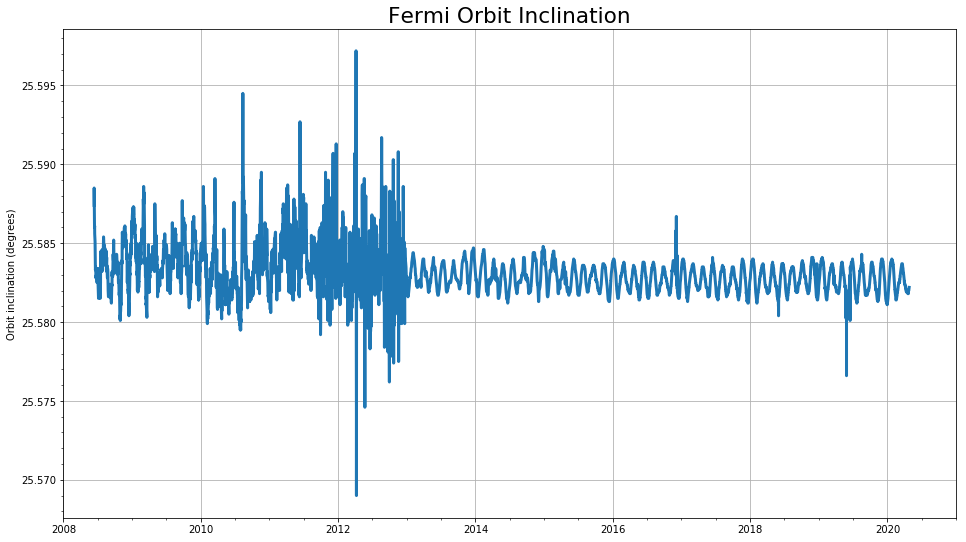

In [6]:
# plot the Fermi orbit inclination

dat = fdf
f,ax = plt.subplots(1, 1, figsize=(16,9))
plt.rc('font', size = 18)
plt.ylabel('Orbit inclination (degrees)')
plt.title('Fermi Orbit Inclination')
plt.xlim(2008,2021)
#plt.ylim(20,30)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(dat['fy'],dat['inc'], '', lw=3)

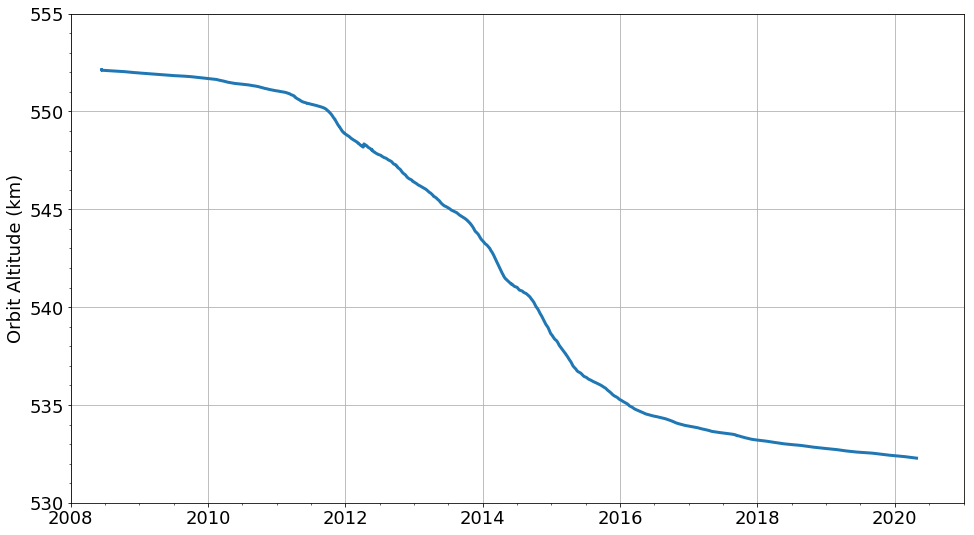

In [7]:
# plot the Fermi orbit altitude

dat = fdf
f,ax = plt.subplots(1, 1, figsize=(16,9))
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.xlim(2008,2021)
plt.ylim(530,555)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(dat['fy'], dat['alt'], '', lw=3)

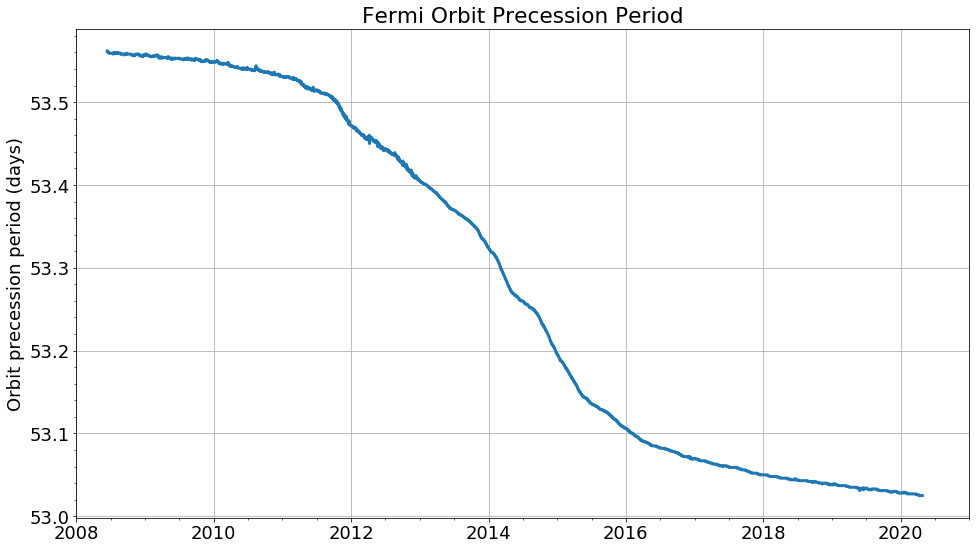

In [8]:
# plot the Fermi orbit precession period

dat = fdf
f,ax = plt.subplots(1, 1, figsize=(16,9))
plt.rc('font', size = 18)
plt.ylabel('Orbit precession period (days)')
plt.title('Fermi Orbit Precession Period')
plt.xlim(2008,2021)
#plt.ylim(20,30)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(dat['fy'], dat['PrecP'], '', lw=3)

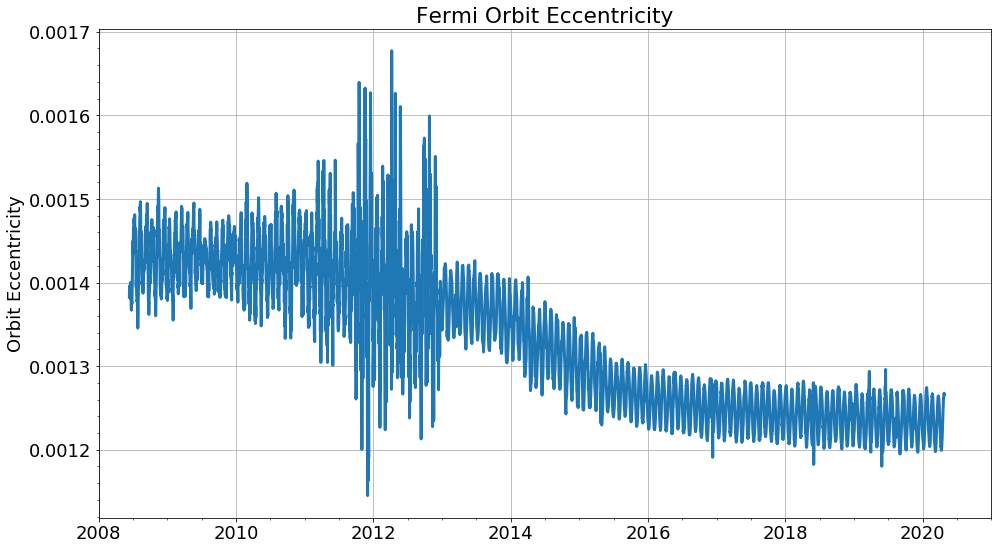

In [9]:
# plot the Fermi orbit eccentricity

dat = fdf
f,ax = plt.subplots(1, 1, figsize=(16,9))
plt.rc('font', size = 18)
plt.ylabel('Orbit Eccentricity')
plt.title('Fermi Orbit Eccentricity')
plt.xlim(2008,2021)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(dat['fy'], dat['ecc'], '', lw=3)

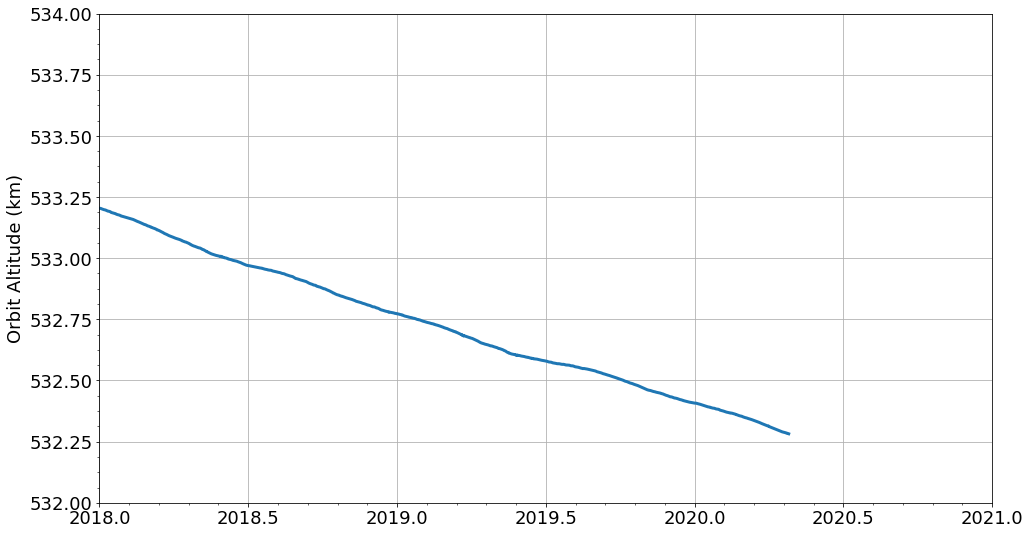

In [10]:
# plot the Fermi orbit altitude

dat = fdf
f,ax = plt.subplots(1, 1, figsize=(16,9))
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.xlim(2018,2021)
plt.ylim(532,534)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(dat['fy'], dat['alt'], '', lw=3)

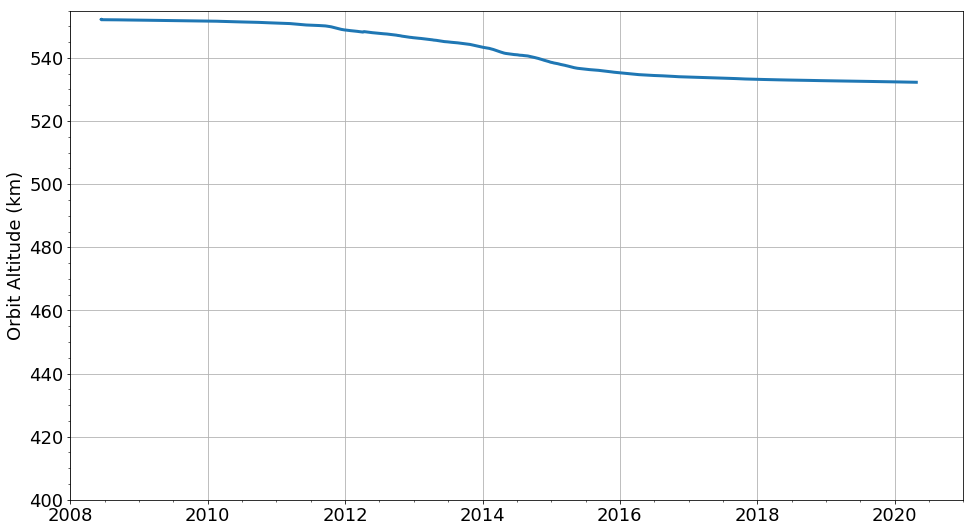

In [11]:
# plot the Fermi orbit altitude

dat = fdf
f,ax = plt.subplots(1, 1, figsize=(16,9))
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.ylim([400,555])
plt.xlim([2008,2021])
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(dat['fy'], dat['alt'], '', lw=3)

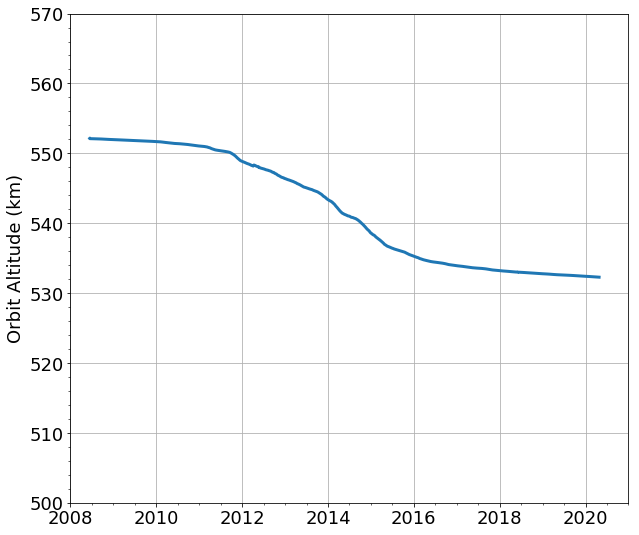

In [12]:
# plot the Fermi orbit altitude

dat = fdf
f,ax = plt.subplots(1, 1, figsize=(10,9))
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.ylim([500,570])
plt.xlim([2008,2021])
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(dat['fy'], dat['alt'], '', lw=3)

plt.savefig(path+"Fermi-alt2020.png")

# Plot STARLINK Orbit Altitude

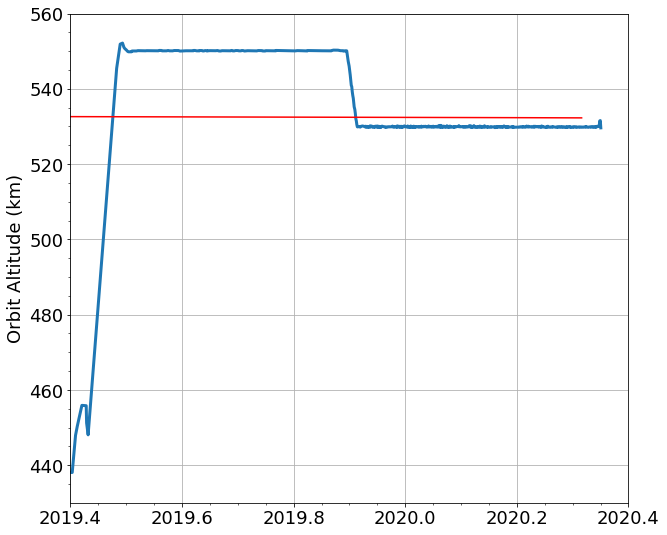

In [13]:
# plot the STARLINK orbit altitude

dat1 = sdf
dat2 = fdf
f,ax = plt.subplots(1, 1, figsize=(10,9))
plt.rc('font', size = 12)
plt.ylabel('Orbit Altitude (km)')
plt.ylim([430,560])
plt.xlim([2019.4,2020.4])
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(dat1['fy'], dat1['alt'], '', lw=3)
plt.plot(dat2['fy'], dat2['alt'], '-',color='r')

# Overlay Fermi and Hubble orbit altitude history

In [14]:
path = "/Users/rac/Documents/GLAST/ISOC/LATmetrics/Hubble-TLE/"
# input file = history listing of TLE orbit parameter records for Fermi
#infile = path+"yy-doy-p.txt"  # obsolete
infile = path + "2020-y-doy-mm.txt"

# read the ASCII data file

cols = ['y','doy','motion','period']
sdf = pd.read_csv(infile,names=cols, delim_whitespace=True)
y = sdf['y']
doy = sdf['doy']
m = sdf['motion']
p = sdf['period']

FileNotFoundError: File b'/Users/rac/Documents/GLAST/ISOC/LATmetrics/Hubble-TLE/2020-y-doy-mm.txt' does not exist

In [ ]:
ylen = y % 4
ylen.where(ylen == 0, other=365, inplace=True)
ylen.where(ylen > 0, other=366, inplace=True)
ylen

hfy = (y + doy/ylen).tolist()

In [ ]:
# calculate orbit altitude from orbit Period (Wertz 1978)
R_earth = 6378
pi = 3.14159265359
GM = 398600.44  # km^3 s^-2 (Wertz 1978)
hsemimajor = (GM*(p/2/pi)**2.0)**0.333333333333   # km
halt = (hsemimajor - R_earth).tolist()    # km

In [ ]:
# plot the Hubble orbit altitude
plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Hubble Orbit Altitude (km)')
plt.xlim(1990,2021)
#plt.ylim(538,540)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(hfy, halt, '.', lw=3,label = 'HST Orbit Altitude')
plt.plot([1990.3,1996.4,2000.8,2009.1,2013.5,2021],[560,540,560,540,560,540],'-x',color='r',label='Solar Min and Max')
plt.quiver([1993.94,1997.13,1999.98,2002.19,2009.38],[579,584,589,564,554],[0,0,0,0,0],[5,5,5,5,5],width=.005,label='Servicing Missions')
plt.legend()

In [ ]:
# plot the Hubble orbit altitude
plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.xlim(1990,2021)
#plt.ylim(538,540)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
plt.plot(hfy, halt, '.', lw=3,label = 'HST Orbit Altitude')
plt.plot(fy, alt, '-',lw=3, label = 'Fermi Orbit Altitude')
plt.plot([1990.3,1996.4,2000.8,2009.1,2013.5,2021],[560,540,560,540,560,540],'-x',color='r',label='Solar Min and Max')
plt.quiver([1993.94,1997.13,1999.98,2002.19,2009.38],[579,584,589,564,554],[0,0,0,0,0],[5,5,5,5,5],width=.005,label='HST Service Missions')
plt.legend()
plt.tick_params(which='major', length=10, width=1, direction='in')
plt.tick_params(which='minor', length=5, width=1, direction='in')

In [ ]:
# plot the Hubble orbit altitude
plt.figure(figsize = [16, 9])
plt.rc('font', size = 18)
plt.ylabel('Orbit Altitude (km)')
plt.xlim(2018,2021)
plt.ylim(532,534)
plt.tick_params(axis = 'both', which = 'major')
plt.tick_params(axis = 'both', which = 'minor')
plt.minorticks_on()
plt.grid(which='major')
plt.ticklabel_format(useOffset=False)
haltm6 = [x - 5.98 for x in halt]
plt.plot(hfy, haltm6, '-', lw=3,label = 'HST orbit altitude change rate')
plt.plot(fy, alt, '-',lw=3, label = 'Fermi orbit altitude change rate')
plt.legend()

In [ ]:
len(fy),len(alt),len(hfy),len(halt)

In [ ]:
fy[-1],fy[-577],alt[-1],alt[-577]

In [ ]:
hfy[-1],hfy[-1456],halt[-1],halt[-1456]

In [ ]:
fslope=(alt[-577]-alt[-1])/(fy[-577]-fy[-1])
fslope

In [ ]:
hslope=(halt[-1456]-halt[-1])/(hfy[-1456]-hfy[-1])
hslope

In [ ]:
5.98/(fslope-hslope)